In [1]:
from gensim import corpora, models, similarities
import pandas as pd
import jieba
from collections import Counter
import seaborn as sns

In [2]:
# read in data

pubhealth = pd.read_csv("PUBHEALTH/train.tsv", sep='\t')
dev = pd.read_csv("PUBHEALTH/dev.tsv", sep='\t')
test = pd.read_csv("PUBHEALTH/test.tsv", sep='\t')

print(len(pubhealth))

# drop columns with no claims
pubhealth = pubhealth.dropna(subset='claim')
print(len(pubhealth))


dev = dev.dropna(subset='claim')
test = test.dropna(subset='claim')

9832
9824


In [4]:
# format tags columns in df

def format_tags(df):
    tags = []
    tag_lists = []

    for subjects in df.subjects:
        if type(subjects) is str:
            s = subjects.split(",")
        else:
            if type(subjects) is list:
                s = subjects
            else:
                s = []
        s = [t.lstrip().rstrip() for t in s]
        tag_lists.append(s)
        for tag in s:
            tags.append(tag)
    df['tags'] = tag_lists
    return df, tags

In [5]:
# format

pubhealth, pubhealth_tags = format_tags(pubhealth)
dev, dev_tags = format_tags(dev)
test, test_tags = format_tags(test)

In [60]:
sorted(set(pubhealth_tags))

['',
 '"',
 '"""cure""',
 '"Georgia',
 '#QAnon',
 '#neveragain',
 '#notonemore',
 '#wastehistime',
 '#wastehistime2016',
 "'true story' jokes",
 '1 October shooting',
 '11 september',
 '1932',
 '1964',
 '1994 crime bill',
 '2015 refugees',
 '2016 election',
 '2016 presidential campaign',
 '2016 presidential election',
 '2016 primary',
 '2017 - The Year in Review',
 '2017 tax bill',
 '2018 elections',
 '2020 election',
 '27 club',
 '2ndvote',
 '48 hour challenge',
 '4chan',
 '4chan hoaxes',
 '4th of july',
 '5g',
 '60 Plus Association',
 '7/11',
 '72 hour challenge',
 '9/11',
 '9/11 Attack on America',
 '9/11 attacks',
 '911 calls',
 'ADHD',
 'ADHD medications',
 'ALD',
 'ALS',
 'AP Fact Check',
 'AP Health',
 'AP International News',
 'AP Politics',
 'AP Science',
 'AP Top News',
 'AP Weekend Reads',
 'ASCO',
 'ASP Article',
 'ASPCA',
 'Aarhus University',
 'Aaron Hernandez',
 'Aberdeen',
 'Abidjan',
 'Abortion',
 'Abu Dhabi',
 'Abuse of women',
 'Academic medical center news release',

In [62]:
pubhealth['health'] = [('Health / Medical' in t) for t in pubhealth.tags]

In [63]:
for i in range(len(pubhealth[pubhealth["health"]])):
    print(pubhealth[pubhealth["health"]].iloc[i]['claim'])
    print(" ")

 The story of an 11-year-old girl who has had        menstrual bleeding since she was 8 and has also started lactating.          The eRumor says it is because she’s been drinking milk injected with rBST,        a hormone given to cows to increase their milk production.  The        eRumor focuses on Wal-Mart Great Value milk as a source of the rBST and        recommends against feeding it to your family.       
 
Fruits and vegetables from other countries are being contaminated with blood containing either AIDS or HIV.
 
 A British man named David Hibbitt was given 18 months to live before he cured cancer with cannabis oil. 
 
 Flu shots contain toxins and ingredients that can destroy your brain and cause Alzheimer’s disease. 
 
 Social media posts claim that Tylenol, Motrin, Zyrtec and Benadryl products for kids and infants have been recalled. 
 
 U.S. Sen. John McCain (R-AZ), while undergoing taxpayer-funded cancer treatments, voted to end cancer treatments for Medicare beneficiaries.

## Use Gensim model with whole training set

In [56]:
# format pubhealth dataset for gensim

claims = list(pubhealth["claim"])
texts = [jieba.lcut(text) for text in claims]
dictionary = corpora.Dictionary(texts)
feature_cnt = len(dictionary.token2id)
corpus = [dictionary.doc2bow(text) for text in texts]
tfidf = models.TfidfModel(corpus)     

In [111]:
#claim = 'Dryer sheets are one of the very worst things from a chemical allergy standpoint.'
# claim = "Chlorine in water causes gray hair."
# claim = 'If you swim in Florida, you can get a flesh-eating bacteria'
# claim = 'You can get HIV from fruits or vegetables from other countries.'
# claim = 'Lead in candles can cause health issues.'
#claim = 'Apple cider vinegar can help with everything including diets. It is great for losing weight.'
# claim = "Don't use baby shampoo! It contains dangerous chemicals like formaldehyde."
claim = "Safflower oil and supplements can help you lose weight.".lower()

In [112]:
# claim

kw_vector = dictionary.doc2bow(jieba.lcut(claim))

# similarity

index = similarities.SparseMatrixSimilarity(tfidf[corpus], num_features = feature_cnt)
sim = index[tfidf[kw_vector]]

In [113]:
sim_df = pd.DataFrame({"claim": claims, "similarity": sim})
sim = sim_df.sort_values("similarity", ascending=False).iloc[0]['similarity']
top_claim = sim_df.sort_values("similarity", ascending=False).iloc[0]['claim']

print("INITIAL CLAIM: ", claim)
print("")
print(sim)
print("")
print("SIMILAR CLAIM: ", top_claim)

INITIAL CLAIM:  safflower oil and supplements can help you lose weight.

0.53099453

SIMILAR CLAIM:   Claims that safflower oil and/or conjugated linoleic acids (CLAs) supplements can help you lose weight, particularly in the belly area, have been circulating for years. 


In [101]:
pubhealth[pubhealth['claim'] == top_claim]['label']

3074    mixture
Name: label, dtype: object

# Gensim model with only health tagged claims

In [49]:
health_tags = ['Health', 'Health News', "Health Care", 'Medical', 'Public Health']

In [50]:
def health(x):
    for t in health_tags:
        if t in x:
            return True
    return False

mask = pubhealth.tags.apply(lambda x: health(x))
health_df = pubhealth[mask]

In [51]:
# format pubhealth dataset for gensim

claims = list(health_df["claim"])
texts = [jieba.lcut(text) for text in claims]
dictionary = corpora.Dictionary(texts)
feature_cnt = len(dictionary.token2id)
corpus = [dictionary.doc2bow(text) for text in texts]
tfidf = models.TfidfModel(corpus) 

In [52]:
#claim = 'Dryer sheets are one of the very worst things from a chemical allergy standpoint.'
#claim = "Chlorine in water causes gray hair."
#claim = 'Cranberry juice is good for UTI.'
#claim = 'My hypothesis is that you should train your body how to properly and quickly flush itself of lactic acid without supplements.'
claim = 'If you swim in Florida, you can get a flesh-eating bacteria'

In [53]:
# claim

kw_vector = dictionary.doc2bow(jieba.lcut(claim))

# similarity

index = similarities.SparseMatrixSimilarity(tfidf[corpus], num_features = feature_cnt)
sim = index[tfidf[kw_vector]]

In [55]:
sim_df = pd.DataFrame({"claim": claims, "similarity": sim})
sim = sim_df.sort_values("similarity", ascending=False).iloc[0]['similarity']
top_claim = sim_df.sort_values("similarity", ascending=False)


print("INITIAL CLAIM: ", claim)
print("")
print(sim)
print("")
print("SIMILAR CLAIM 1: ", top_claim.iloc[0]['claim'])
print("")
print("SIMILAR CLAIM 2: ", top_claim.iloc[1]['claim'])
print("")
print("SIMILAR CLAIM 3: ", top_claim.iloc[2]['claim'])

INITIAL CLAIM:  If you swim in Florida, you can get a flesh-eating bacteria

0.27792567

SIMILAR CLAIM 1:  Britain to reveal trial criteria for coronavirus antibody tests.

SIMILAR CLAIM 2:  “You know what’s in this bill? No medical malpractice suits until 2024, even if they’re not COVID related.”

SIMILAR CLAIM 3:  First flu death of season recorded in Utah.


In [163]:
pubhealth[pubhealth['claim'] == top_claim]

,claim_id,claim,date_published,explanation,fact_checkers,main_text,sources,label,subjects,tags
8485,34070,Mixing cream of tartar with orange juice will ...,"October 24, 2019",Because no published support exists for the cl...,Alex Kasprak,A viral story on Shareably first published in ...,,false,Medical,[Medical]


## Gensim model with only health tagged claims tested on dev set

In [165]:
dev_mask = dev.tags.apply(lambda x: health(x))
dev_health_df = dev[mask]

/var/folders/__/6ygy68tn6c74340_57scyx500000gn/T/ipykernel_67600/2225327524.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dev_health_df = dev[mask]


In [170]:
len(dev_health_df)

448

In [176]:
initial_claims = []
initial_label = []
gensim_claims = []
gensim_label = []
sims = []

for i in range(len(dev_health_df['claim'])):
    # claim
    if i % 25 == 0:
        print("On " + str(i) + " out of " + str(len(dev_health_df)))
    claim = dev_health_df.iloc[i]['claim']
    kw_vector = dictionary.doc2bow(jieba.lcut(claim))

    # similarity
    index = similarities.SparseMatrixSimilarity(tfidf[corpus], num_features = feature_cnt)
    sim = index[tfidf[kw_vector]]
    
    sim_df = pd.DataFrame({"claim": claims, "similarity": sim})
    sim = sim_df.sort_values("similarity", ascending=False).iloc[0]['similarity']
    top_claim = sim_df.sort_values("similarity", ascending=False).iloc[0]['claim']
    top_label = pubhealth[pubhealth['claim'] == top_claim].iloc[0]['label']
    
    initial_claims.append(claim)
    initial_label.append(dev_health_df[dev_health_df["claim"] == claim].iloc[0]['label'])
    sims.append(sim)
    gensim_claims.append(top_claim)
    gensim_label.append(top_label)

On 0 out of 448
On 25 out of 448
On 50 out of 448
On 75 out of 448
On 100 out of 448
On 125 out of 448
On 150 out of 448
On 175 out of 448
On 200 out of 448
On 225 out of 448
On 250 out of 448
On 275 out of 448
On 300 out of 448
On 325 out of 448
On 350 out of 448
On 375 out of 448
On 400 out of 448
On 425 out of 448


In [177]:
final_dev = pd.DataFrame({"initial claim": initial_claims, \
                          "initial label": initial_label, \
                          "gensim claim": gensim_claims, \
                          "gensim label": gensim_label, \
                          "similarity": sims})

In [181]:
final_dev

,initial claim,initial label,gensim claim,gensim label,similarity
0,School closures will have little impact on COV...,true,School district offer birth control in high sc...,true,0.273244
1,More infected in fresh wave of China bird flu ...,true,Death toll from new China bird flu rises: WHO.,true,0.345577
2,Raw Milk Straight from the Cow,true,Straight-talking Fauci explains outbreak to a ...,true,0.420198
3,Trump: Asian-Americans not responsible for vir...,true,Heroic nurses need full protection against cor...,true,0.339628
4,"November 29, 2017","National, Candidate Biography, Donald Trump,",The FDA published “conclusive proof” that the...,false,0.327621
...,...,...,...,...,...
443,"We're not engaged in nation-building"" in Afgha...",mixture,“We’re down near the low end of per capita dea...,false,0.227977
444,There are reports of suicides and even murd...,mixture,"This is COVID-19, not COVID-1, folks. And so y...",false,0.179715
445,"The state of Florida has seen ""double-digit dr...",true,"""Sexting"""" again linked to risky sex among tee...",true,0.309186
446,Sylentis announces the results of tivanisiran ...,mixture,Minnesota OKs medical cannabis for chronic pai...,true,0.202549


In [198]:
final_dev['score'] = final_dev['initial label'] == final_dev['gensim label']

# average score for all predictions

sum(final_dev['score'])/len(final_dev)

0.5580357142857143

/var/folders/__/6ygy68tn6c74340_57scyx500000gn/T/ipykernel_67600/3482985148.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x=final_dev['similarity'],bins=10,kde=False)


<AxesSubplot: >

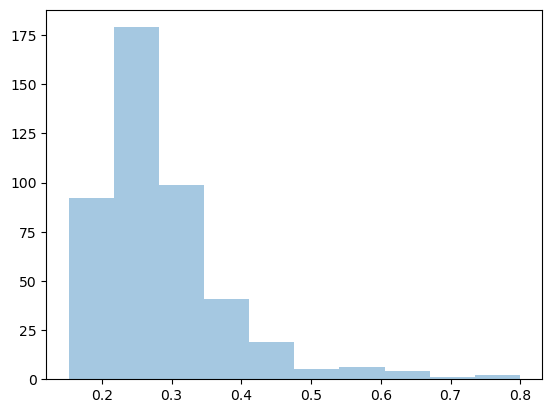

In [197]:
# looking at overall similarity scores

sns.distplot(x=final_dev['similarity'],bins=10,kde=False)

In [204]:
# average score for predictions with over .3 similarity

sum(final_dev[final_dev['similarity'] > 0.3]['score'])/len(final_dev[final_dev['similarity'] > 0.3])

0.6896551724137931

In [205]:
# average score for predictions with over .4 similarity

sum(final_dev[final_dev['similarity'] > 0.4]['score'])/len(final_dev[final_dev['similarity'] > 0.4])

0.8

In [206]:
# average score for predictions with over .4 similarity

sum(final_dev[final_dev['similarity'] > 0.5]['score'])/len(final_dev[final_dev['similarity'] > 0.5])

0.9333333333333333

## Normal Classifiers